In [1]:
from tqdm.notebook import tqdm
import numpy as np
import pandas as pd
import os,cv2,gc

import soundfile
import librosa
import random
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import StratifiedKFold

from fastai.vision.all import *
from radam import *

In [2]:
PATH = 'data/train_short_audio'
LABELS = 'data/train_metadata.csv'
PATH_VAL = 'data/train_soundscapes/'
LABELS_VAL = 'data/train_soundscape_labels.csv'
NUM_WORKERS = 12
nfolds = 4
SEED = 2020
OUT = 'shift'
bs = 156

class config:
    sampling_rate = 32000
    duration = 5.0075#10.015#20.03
    sz = int(16*duration/5.007+0.5)
    samples = int(sampling_rate*duration)
    samples_val = int(sampling_rate*5.0075)
    top_db = 60 # Noise filtering, default = 60
    
    # Frequencies kept in spectrograms
    fmin = 50
    fmax =  14000

    # Spectrogram parameters
    n_mels = 128
    n_fft = 1024
    hop_length = 313
    
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

os.makedirs(OUT, exist_ok=True)
seed_everything(SEED)

In [3]:
df = pd.read_csv(LABELS)
label_map = {p:i for i,p in enumerate(sorted(df.primary_label.unique()))}
df['label'] = df.primary_label.map(label_map)
df['label_s'] = [[label_map[e.split('_')[-1]] for e in l.split('\'')[1::2] if e.split('_')[-1] in label_map] \
       for l in df.secondary_labels] 

splits = StratifiedKFold(n_splits=nfolds, random_state=SEED, shuffle=True)
df['split'] = 0
for i,s in enumerate(list(splits.split(df,df.label))): df.loc[s[1],'split'] = i
df['fname'] = [os.path.join(PATH,l,f) for f,l in zip(df.filename,df.primary_label)]
df.head()

,primary_label,secondary_labels,type,latitude,longitude,scientific_name,common_name,author,date,filename,license,rating,time,url,label,label_s,split,fname
0,acafly,['amegfi'],"['begging call', 'call', 'juvenile']",35.3860,-84.1250,Empidonax virescens,Acadian Flycatcher,Mike Nelson,2012-08-12,XC109605.ogg,Creative Commons Attribution-NonCommercial-ShareAlike 3.0,2.5,09:30,https://www.xeno-canto.org/109605,0,[5],0,data/train_short_audio/acafly/XC109605.ogg
1,acafly,[],['call'],9.1334,-79.6501,Empidonax virescens,Acadian Flycatcher,Allen T. Chartier,2000-12-26,XC11209.ogg,Creative Commons Attribution-NonCommercial-ShareAlike 3.0,3.0,?,https://www.xeno-canto.org/11209,0,[],2,data/train_short_audio/acafly/XC11209.ogg
2,acafly,[],['call'],5.7813,-75.7452,Empidonax virescens,Acadian Flycatcher,Sergio Chaparro-Herrera,2012-01-10,XC127032.ogg,Creative Commons Attribution-NonCommercial-ShareAlike 3.0,3.0,15:20,https://www.xeno-canto.org/127032,0,[],3,data/train_short_audio/acafly/XC127032.ogg
3,acafly,['whwbec1'],['call'],4.6717,-75.6283,Empidonax virescens,Acadian Flycatcher,Oscar Humberto Marin-Gomez,2009-06-19,XC129974.ogg,Creative Commons Attribution-NonCommercial-ShareAlike 3.0,3.5,07:50,https://www.xeno-canto.org/129974,0,[370],3,data/train_short_audio/acafly/XC129974.ogg
4,acafly,['whwbec1'],['call'],4.6717,-75.6283,Empidonax virescens,Acadian Flycatcher,Oscar Humberto Marin-Gomez,2009-06-19,XC129981.ogg,Creative Commons Attribution-NonCommercial-ShareAlike 3.0,3.5,07:50,https://www.xeno-canto.org/129981,0,[370],0,data/train_short_audio/acafly/XC129981.ogg


In [4]:
noise_split = [['7954_COR_20190923.ogg','11254_COR_20190904.ogg','54955_SSW_20170617.ogg',
 '51010_SSW_20170513.ogg','18003_COR_20190904.ogg'],
['7019_COR_20190904.ogg','14473_SSW_20170701.ogg','57610_COR_20190904.ogg',
'44957_COR_20190923.ogg','21767_COR_20190904.ogg'],
['31928_COR_20191004.ogg','50878_COR_20191004.ogg','42907_SSW_20170708.ogg',
 '26709_SSW_20170701.ogg','28933_SSW_20170408.ogg'],
['20152_SSW_20170805.ogg','7843_SSW_20170325.ogg','26746_COR_20191004.ogg',
 '10534_SSW_20170429.ogg','2782_SSW_20170701.ogg']]

In [5]:
from numpy import sqrt, newaxis
from numpy.fft import irfft, rfftfreq
from numpy.random import normal
from numpy import sum as npsum


def powerlaw_psd_gaussian(exponent, size, fmin=0):
    """Gaussian (1/f)**beta noise.
    Based on the algorithm in:
    Timmer, J. and Koenig, M.:
    On generating power law noise.
    Astron. Astrophys. 300, 707-710 (1995)
    Normalised to unit variance
    Parameters:
    -----------
    exponent : float
        The power-spectrum of the generated noise is proportional to
        S(f) = (1 / f)**beta
        flicker / pink noise:   exponent beta = 1
        brown noise:            exponent beta = 2
        Furthermore, the autocorrelation decays proportional to lag**-gamma
        with gamma = 1 - beta for 0 < beta < 1.
        There may be finite-size issues for beta close to one.
    shape : int or iterable
        The output has the given shape, and the desired power spectrum in
        the last coordinate. That is, the last dimension is taken as time,
        and all other components are independent.
    fmin : float, optional
        Low-frequency cutoff.
        Default: 0 corresponds to original paper. It is not actually
        zero, but 1/samples.
    Returns
    -------
    out : array
        The samples.
    Examples:
    ---------
    # generate 1/f noise == pink noise == flicker noise
    >>> import colorednoise as cn
    >>> y = cn.powerlaw_psd_gaussian(1, 5)
    """
    
    # Make sure size is a list so we can iterate it and assign to it.
    try:
        size = list(size)
    except TypeError:
        size = [size]
    
    # The number of samples in each time series
    samples = size[-1]
    
    # Calculate Frequencies (we asume a sample rate of one)
    # Use fft functions for real output (-> hermitian spectrum)
    f = rfftfreq(samples)
    
    # Build scaling factors for all frequencies
    s_scale = f
    fmin = max(fmin, 1./samples) # Low frequency cutoff
    ix   = npsum(s_scale < fmin)   # Index of the cutoff
    if ix and ix < len(s_scale):
        s_scale[:ix] = s_scale[ix]
    s_scale = s_scale**(-exponent/2.)
    
    # Calculate theoretical output standard deviation from scaling
    w      = s_scale[1:].copy()
    w[-1] *= (1 + (samples % 2)) / 2. # correct f = +-0.5
    sigma = 2 * sqrt(npsum(w**2)) / samples
    
    # Adjust size to generate one Fourier component per frequency
    size[-1] = len(f)

    # Add empty dimension(s) to broadcast s_scale along last
    # dimension of generated random power + phase (below)
    dims_to_add = len(size) - 1
    s_scale     = s_scale[(newaxis,) * dims_to_add + (Ellipsis,)]
    
    # Generate scaled random power + phase
    sr = normal(scale=s_scale, size=size)
    si = normal(scale=s_scale, size=size)
    
    # If the signal length is even, frequencies +/- 0.5 are equal
    # so the coefficient must be real.
    if not (samples % 2): si[...,-1] = 0
    
    # Regardless of signal length, the DC component must be real
    si[...,0] = 0
    
    # Combine power + corrected phase to Fourier components
    s  = sr + 1J * si
    
    # Transform to real time series & scale to unit variance
    y = irfft(s, n=samples, axis=-1) / sigma
    
    return y

In [6]:
mean,std = -40.0,12.0 #quick estimation

def img2tensor(img,dtype:np.dtype=np.float32):
    if img.ndim==2 : img = np.expand_dims(img,2)
    img = np.transpose(img,(2,0,1))
    return torch.from_numpy(img.astype(dtype, copy=False))

class BirdDatasetS(Dataset):
    def __init__(self, df, PL, fold=0, train=True, tfms=None, noise=True):
        self.df = df.copy()
        self.df = self.df.loc[self.df.split != fold] if train else self.df.loc[self.df.split == fold]
        self.df = self.df.reset_index(drop=True)
        self.train = train
        self.tfms = tfms
        self.noise = None
        self.pl = pickle.load(open(PL,'rb')) if PL is not None else None
        self.pl_th1 = 0.6
        self.pl_th2 = -1.5
        
        self.noise = None
        if self.train and noise:
            noise = [np.load(f'data/noise_{fold}')]
            files = os.listdir('data/noise0/')
            np.random.shuffle(files)
            for f in files:
                w, sr = soundfile.read(os.path.join('data/noise0/',f))
                noise.append(w.astype(np.float32))
            self.noise = np.concatenate(noise)
        self.pink = 0.001*powerlaw_psd_gaussian(1,5000*config.sampling_rate) #0.002
        
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        while True:
            label,label_s,fname,fidx = self.df.iloc[idx][['label','label_s','fname','filename']]
            f = soundfile.info(fname)
            l = f.frames
            assert(f.samplerate == config.sampling_rate)
            pl = self.pl[fidx]
            selection = pl[label] > self.pl_th1
            if selection.max(): break
            else: idx = np.random.randint(len(self.df))
            
        ids = torch.where(selection)[0]
        pl_start = ids[random.randint(0,len(ids)-1)]
        pl_start = max(0,pl_start-random.randint(0,config.sz-2))
        pl_end = pl_start + config.sz
        if pl_end > pl.shape[1]: 
            pl_end = pl.shape[1]
            pl_start = max(0,pl_end - config.sz)
        pl = pl[:,pl_start:pl_end]
        if config.sz - pl_end+pl_start != 0: pl = F.pad(pl,[0,config.sz-pl_end+pl_start,0,0])
        
        effective_length = config.samples
        start = max(0,min(int((pl_start)*32*config.hop_length + random.randint(0,config.n_fft) +
                          random.randint(-4*config.hop_length,4*config.hop_length)),
                          l - effective_length))
        if l <= effective_length: wave, sr = soundfile.read(fname)
        else: wave, sr = soundfile.read(fname,start=start,stop=start+effective_length)
        if effective_length > len(wave): wave = np.pad(wave,(0,effective_length - len(wave)))
        wave= wave.astype(np.float32)
        if self.train:
            shape = wave.shape[0]
            s_idx = np.random.randint(self.pink.shape[0] - shape)
            noise = self.pink[s_idx:s_idx+shape]
            if self.noise is not None:
                s_idx = np.random.randint(self.noise.shape[0] - shape)
                noise = 0.5*self.noise[s_idx:s_idx+shape] + noise
            wave = min(1.0,max(0.15,np.random.exponential(0.3)))*wave+noise

        mel = librosa.feature.melspectrogram(wave, 
                    sr=config.sampling_rate,
                    n_mels=config.n_mels,
                    hop_length=config.hop_length,
                    n_fft=config.n_fft,
                    fmin=config.fmin,
                    fmax=config.fmax)
        logmel = librosa.power_to_db(mel).astype(np.float32)
        label = F.one_hot(torch.LongTensor([label]), len(label_map)).float().squeeze()
        if len(label_s) > 0: label += 0.5*F.one_hot(torch.LongTensor(label_s), len(label_map)).float().sum(0)
        maskp = pl > self.pl_th1
        maskn = pl > self.pl_th2
        maskn[~((label > 0) | maskp.max(-1)[0]).unsqueeze(-1).repeat(1,config.sz)] = False
        return {'spec':(img2tensor(logmel) - mean)/std}, \
            {'label':label*0.999 + 0.001, 'pl_maskp': maskp if pl is not None else None, \
             'pl_maskn':maskn if pl is not None else None}

In [7]:
class BirdDatasetVal(Dataset):
    def __init__(self,fold):
        df = pd.read_csv(LABELS_VAL)
        df['file'] = ['_'.join(row.row_id.split('_')[:-1]) for idx,row in df.iterrows()]
        df['birds'] = [[label_map[b] for b in row.birds.split(' ') if b in label_map] for idx,row in df.iterrows()]
        file_map = {'_'.join(f.split('_')[:-1]):f for f in os.listdir(PATH_VAL)}
        df['file'] = df.file.map(file_map)
        if fold < len(noise_split): self.df = df[df.file.isin(noise_split[fold])]
        elif fold == 4: self.df = df.loc[df.seconds <= 300].reset_index(drop=True)
        else: self.df = df.loc[df.seconds > 300].reset_index(drop=True)
        self.data = {fname:soundfile.read(os.path.join(PATH_VAL,fname))[0] for fname in list(df.file.unique())}
        
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        label,fname,end = self.df.iloc[idx][['birds','file','seconds']]
        end *= config.sampling_rate
        length = config.samples_val
        start = max(0, end - length)
        
        wave = self.data[fname][start:start+length]
        mel = librosa.feature.melspectrogram(wave, 
                    sr=config.sampling_rate,
                    n_mels=config.n_mels,
                    hop_length=config.hop_length,
                    n_fft=config.n_fft,
                    fmin=config.fmin,
                    fmax=config.fmax)
        logmel = librosa.power_to_db(mel).astype(np.float32)
        label = F.one_hot(torch.LongTensor(label), len(label_map)).float().sum(0) if len(label) > 0 \
          else torch.zeros(len(label_map))
        return {'spec':(img2tensor(logmel) - mean)/std}, {'label':label*0.999 + 0.001}    

In [8]:
class AttnBlock(nn.Module):
    def __init__(self, n=512, nheads=8, dim_feedforward=512):
        super().__init__()
        self.attn = nn.MultiheadAttention(n,nheads)
        self.norm = nn.LayerNorm(n)
        self.drop = nn.Dropout(0.2)
        
    def forward(self, x):
        shape = x.shape
        x = x.view(shape[0],shape[1],-1).permute(2,0,1)
        x = self.norm(self.drop(self.attn(x,x,x)[0]) + x)
        x = x.permute(1,2,0).reshape(shape)
        return x    

class Model(nn.Module):
    def __init__(self, n=len(label_map), arch='resnext50_32x4d_ssl', 
                 path='facebookresearch/semi-supervised-ImageNet1K-models', ps=0.5, 
                 s_max = 5.0, s_min=-2.0):
        super().__init__()
        self.s_max,self.s_min = s_max,s_min
        m = torch.hub.load(path, arch)
        nc = list(m.children())[-1].in_features
        self.enc = nn.Sequential(*list(m.children())[:-2])
        
        shape = self.enc[0].weight.shape
        w = self.enc[0].weight.sum(1).unsqueeze(1)
        self.enc[0] = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        self.enc[0].weight = nn.Parameter(w)

        nh = 768
        self.head = nn.Sequential(nn.Conv2d(nc,nh,(config.n_mels//32,1)),AttnBlock(nh),AttnBlock(nh),
                                  nn.Conv2d(nh,n,1))
        
    def forward(self, x):
        x = self.head(self.enc(x['spec']))
        #bs,n,1,len//32
        x_g = torch.logsumexp(x*self.s_max,-1).squeeze(-1)/self.s_max
        x_min = torch.logsumexp(x*self.s_min,-1).squeeze(-1)/self.s_min
        return {'pred':x.squeeze(2), 'pred_g':x_g, 'pred_min':x_min}
        
    split_layers = lambda m: [list(m.module.enc.parameters()), list(m.module.head.parameters())]

In [10]:
from madgrad import MADGRAD
from radam import Over9000

def WrapperMADGRAD(param_groups,**kwargs):
    return OptimWrapper(param_groups,MADGRAD)

def WrapperOver9000(param_groups,**kwargs):
    return OptimWrapper(param_groups,Over9000)

In [11]:
#correct implementation of focal loss for soft labels
class FocalLoss(nn.Module):
    def __init__(self, gamma=2):
        super().__init__()
        self.gamma = gamma
        
    def forward(self, input, target, reduction='mean'):
        #n = input.shape[-1]
        input = input.view(-1).float()
        target = target.view(-1).float()
        loss = -target*F.logsigmoid(input)*torch.exp(self.gamma*F.logsigmoid(-input)) -\
           (1.0 - target)*F.logsigmoid(-input)*torch.exp(self.gamma*F.logsigmoid(input))
        
        return loss.mean() if reduction=='mean' else loss
    
#correct implementation of focal loss for soft labels
class CombineLoss(nn.Module):
    def __init__(self, gamma=2, mul=1.0):
        super().__init__()
        self.floss = FocalLoss(gamma)
        self.mul = mul
        
    def forward(self, x, y, reduction='mean'):
        if 'pl_maskp' not in y:
            return self.mul*self.floss(x['pred_g'],y['label']) + \
              0.3*self.floss(x['pred_min'],torch.zeros_like(y['label']))
        yg = torch.max(y['label'],0.85*y['pl_maskp'].max(-1)[0])
        loss_g = self.floss(x['pred_g'],yg) + 0.3*self.floss(x['pred_min'],torch.zeros_like(y['label']))
        if 'pl_maskp' not in y: return loss_g*self.mul
        m = (~y['pl_maskn'] | y['pl_maskp'])
        loss_s = self.floss(x['pred'][m],y['pl_maskp'][m])
        return self.mul*(0.5*loss_g + 0.5*loss_s)

In [12]:
def acc_m(x,y):
    return (x['pred_g'].argmax(-1) == y['label'].argmax(-1)).float().mean()

def fbeta(y_pred:Tensor, y_true:Tensor, thresh:float=0.2, beta:float=2, eps:float=1e-9, sigmoid:bool=True):
    "Computes the f_beta between `preds` and `targets`"
    beta2 = beta ** 2
    if sigmoid: y_pred = y_pred.sigmoid()
    y_pred = (y_pred>thresh).float()
    y_true = y_true.float()
    TP = (y_pred*y_true).sum(dim=1)
    prec = TP/(y_pred.sum(dim=1)+eps)
    rec = TP/(y_true.sum(dim=1)+eps)
    res = (prec*rec)/(prec*beta2+rec+eps)*(1+beta2)
    return res.mean()

class FBetaMax(Metric):
    def __init__(self, beta=1):
        super().__init__()
        self.beta = beta
        self.preds = []
        self.targets = []
        
    def reset(self): 
        self.preds = []
        self.targets = []
        
    def accumulate(self,learn):
        x = learn.pred['pred_g'].cpu() 
        x = torch.cat([x,-x.max(-1)[0].unsqueeze(-1)],1) #account for nocall
        y = learn.y['label'].cpu()
        y = torch.cat([y,1 - y.max(-1)[0].unsqueeze(-1)],1)
        self.preds.append(learn.pred['pred_g'].cpu())
        self.targets.append(learn.y['label'].cpu())
    
    @property
    def value(self):
        p = torch.cat(self.preds,0)
        t = torch.cat(self.targets,0)
        th1,th2 = p.min(), p.max()
        nth = 100
        metric = torch.stack([fbeta(p,t,thresh=th1+(th2-th1)*i/(nth-1),
                                    beta=self.beta,sigmoid=False) for i in range(nth)]).max()
        return metric

class F1_row(Metric):
    def __init__(self,ths=np.arange(-2.5,2.5,0.05)):
        super().__init__()
        self.ths = ths
        self.f1s = []
        
    def reset(self): 
        self.f1s = []
        
    def accumulate(self,learn):
        f1s = []
        for th in self.ths:
            pred = (learn.pred['pred'].max(-1)[0] > th).cpu()
            t = learn.y['label'].long().cpu()
            f1 = (2.0*(pred*t).sum(1)+1e-6)/(pred.sum(1) + t.sum(1) + 1e-6)
            f1s.append(f1)
        self.f1s.append(f1s)
    
    @property
    def value(self):
        f1 = torch.cat([torch.stack(f,1) for f in self.f1s],0).mean(0)
        return f1.max()
    
    
class AccMax(Metric):
    def __init__(self, beta=1):
        super().__init__()
        self.beta = beta
        self.preds = []
        self.targets = []
        
    def reset(self): 
        self.preds = []
        self.targets = []
        
    def accumulate(self,learn):
        self.preds.append(learn.pred['pred_g'].cpu())
        self.targets.append(learn.y['label'].cpu())
        
    def get_metric(self,p,t,th):
        return ((p > th).long() == t.long()).min(-1)[0].float().mean()
    
    @property
    def value(self):
        p = torch.cat(self.preds,0)
        t = torch.cat(self.targets,0)
        th1,th2 = p.min(), p.max()
        nth = 100
        metric = torch.stack([self.get_metric(p,t,th1+(th2-th1)*i/(nth-1)) for i in range(nth)]).max()
        return metric

In [13]:
class MixUp_audio(MixHandler):
    "Implementation of https://arxiv.org/abs/1710.09412"
    def __init__(self, alpha=4.0, p=0.6): 
        super().__init__(alpha)
        self.p = p
        
    def before_batch(self):
        if random.random() > self.p: return
        lam = self.distrib.sample((self.y['label'].size(0),)).squeeze().to(self.x['spec'].device)
        lam = torch.stack([lam, 1-lam], 1)
        self.lam = lam.max(1)[0]
        shuffle = torch.randperm(self.y['label'].size(0)).to(self.x['spec'].device)
        xb1,yb1 = self.x['spec'][shuffle],self.y['label'][shuffle]
        nx_dims = len(self.x['spec'].size())
        self.learn.x.update({'spec':torch.lerp(xb1,self.x['spec'],unsqueeze(self.lam, n=nx_dims-1))})
        self.learn.y.update({'label':torch.max(yb1,self.y['label'])})

In [14]:
from torch.cuda.amp import GradScaler, autocast
@delegates(GradScaler)
class MixedPrecision(Callback):
    "Mixed precision training using Pytorch's `autocast` and `GradScaler`"
    order = 10
    def __init__(self, **kwargs): self.kwargs,self.autocast = kwargs,autocast()
    def before_fit(self): self.learn.scaler,self.scales = GradScaler(**self.kwargs),L()
    def before_batch(self): self.autocast.__enter__()
    def after_pred(self): self.learn.pred = to_float(self.pred) ###
    def after_loss(self): self.autocast.__exit__()
    def before_backward(self): self.learn.loss_grad = self.scaler.scale(self.loss_grad)
    def before_step(self):
        self.skipped=True
        self.scaler.step(self)
        if self.skipped: raise CancelStepException()
        self.scales.append(self.scaler.get_scale())
    def after_step(self): self.learn.scaler.update()

    @property # pretend to be an optimizer for `GradScaler`
    def param_groups(self): return self.opt.param_groups
    def step(self, *args, **kwargs): self.skipped=False
        
import fastai
fastai.callback.fp16.MixedPrecision = MixedPrecision

Using cache found in /home/iafoss/.cache/torch/hub/facebookresearch_semi-supervised-ImageNet1K-models_master


epoch,train_loss,valid_loss,f1_row,time
0,2.901481,2.060566,0.628334,03:56


epoch,train_loss,valid_loss,f1_row,time
0,2.525031,1.952308,0.628334,04:02
1,2.361328,1.751676,0.628334,03:58
2,2.263933,1.823325,0.636111,04:01
3,2.160940,2.083967,0.647223,04:01
4,2.124147,2.003517,0.648889,03:59
5,2.070915,1.905370,0.642222,03:59
6,1.945821,1.898707,0.635000,04:04
7,2.032737,1.945907,0.644445,04:00
8,1.976719,1.890322,0.642778,04:00
9,1.871781,1.855168,0.707222,04:02


Better model found at epoch 0 with f1_row value: 0.6283336281776428.
Better model found at epoch 2 with f1_row value: 0.6361114382743835.
Better model found at epoch 3 with f1_row value: 0.6472225189208984.
Better model found at epoch 4 with f1_row value: 0.6488891839981079.
Better model found at epoch 9 with f1_row value: 0.7072224020957947.
Better model found at epoch 13 with f1_row value: 0.7461113333702087.
Better model found at epoch 17 with f1_row value: 0.748611330986023.


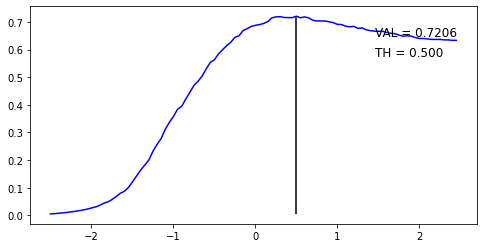

Using cache found in /home/iafoss/.cache/torch/hub/facebookresearch_semi-supervised-ImageNet1K-models_master


epoch,train_loss,valid_loss,f1_row,time
0,2.985754,1.917779,0.652445,03:56


epoch,train_loss,valid_loss,f1_row,time
0,2.650632,1.986008,0.650000,03:59
1,2.435175,1.995893,0.650000,03:59
2,2.240768,1.795290,0.662500,03:59
3,2.236890,1.924477,0.650000,04:01
4,2.093936,1.898907,0.688334,04:01
5,2.091392,1.781530,0.690778,04:00
6,2.041513,1.752197,0.687389,03:57
7,1.999629,1.778910,0.681945,04:00
8,1.933932,1.779554,0.700667,04:00
9,1.897011,1.851949,0.665000,04:02


Better model found at epoch 0 with f1_row value: 0.6500003337860107.
Better model found at epoch 2 with f1_row value: 0.6625003218650818.
Better model found at epoch 4 with f1_row value: 0.6883335113525391.
Better model found at epoch 5 with f1_row value: 0.6907780170440674.
Better model found at epoch 8 with f1_row value: 0.7006669044494629.
Better model found at epoch 12 with f1_row value: 0.7131112813949585.
Better model found at epoch 14 with f1_row value: 0.7316668629646301.
Better model found at epoch 20 with f1_row value: 0.7359446883201599.
Better model found at epoch 23 with f1_row value: 0.7456668019294739.


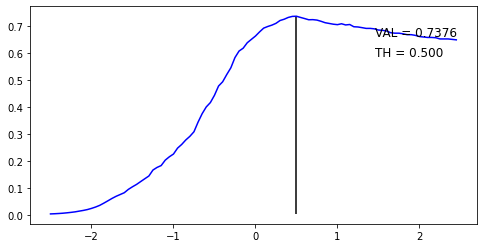

Using cache found in /home/iafoss/.cache/torch/hub/facebookresearch_semi-supervised-ImageNet1K-models_master


epoch,train_loss,valid_loss,f1_row,time
0,2.983109,2.315295,0.610000,04:00


epoch,train_loss,valid_loss,f1_row,time
0,2.559456,2.225976,0.618334,04:00
1,2.434551,2.185114,0.616111,03:59
2,2.250982,1.964177,0.631778,03:56
3,2.079795,2.013826,0.640056,03:58
4,2.189238,2.222279,0.620834,03:58
5,2.056339,1.980339,0.655667,03:57
6,2.050642,1.984873,0.633889,03:59
7,1.943078,2.082917,0.647000,04:00
8,1.913789,2.075519,0.628167,03:58
9,1.996397,1.935792,0.670834,03:59


Better model found at epoch 0 with f1_row value: 0.618333637714386.
Better model found at epoch 2 with f1_row value: 0.6317780017852783.
Better model found at epoch 3 with f1_row value: 0.6400557160377502.
Better model found at epoch 5 with f1_row value: 0.6556668877601624.
Better model found at epoch 9 with f1_row value: 0.6708335280418396.
Better model found at epoch 13 with f1_row value: 0.6716113090515137.
Better model found at epoch 15 with f1_row value: 0.6734446287155151.
Better model found at epoch 16 with f1_row value: 0.6744446158409119.
Better model found at epoch 19 with f1_row value: 0.7187779545783997.


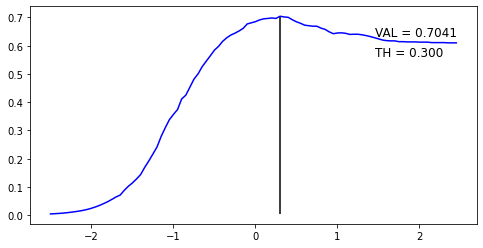

In [17]:
fname = 'shift7'
for fold in range(6):
    gc.collect()
    ds_t = BirdDatasetS(df, fold=fold, PL=f'data/seg0_pl.pickle',train=True)#,noise_path=NOISE_PATH)
    ds_v = BirdDatasetVal(fold=fold)
    data = ImageDataLoaders.from_dsets(ds_t,ds_v,bs=bs,num_workers=NUM_WORKERS,pin_memory=True).cuda()
    gc.collect()
    model = Model().cuda()
    model = nn.DataParallel(model)

    learn = Learner(data, model, loss_func=CombineLoss(mul=len(label_map)),
                    metrics=[F1_row()],opt_func=partial(WrapperOver9000,eps=1e-4),
                    cbs=[GradientClip(),MixUp_audio(p=0.8)],splitter=Model.split_layers).to_fp16()

    learn.freeze_to(-1)
    learn.fit_one_cycle(1, lr_max=1e-2, div=5, pct_start=0.0)
    torch.cuda.empty_cache()
    learn.unfreeze()
    learn.fit_one_cycle(28, lr_max=(1e-3,0.2e-2), pct_start=0.0, div=50, div_final=100,moms=[0.91,0.85,0.91],
            cbs=SaveModelCallback(monitor='f1_row',comp=np.greater))
    torch.save(learn.model.module.state_dict(),os.path.join(OUT,f'{fname}_{fold}.pth'))
    
    values = torch.cat([torch.stack(f,1) for f in learn.metrics[0].f1s],0).mean(0)
    values_ths = learn.metrics[0].ths
    best_val = values.max()
    best_th = values_ths[values.argmax()]
    plt.figure(figsize=(8,4))
    plt.plot(values_ths, values, color='blue')
    plt.vlines(x=best_th, ymin=values.min(), ymax=values.max(), colors='black')
    d = values.max() - values.min()
    dth = values_ths.max() - values_ths.min()
    plt.text(values_ths[-1]-0.2*dth, best_val-0.1*d, f'VAL = {best_val:.4f}', fontsize=12);
    plt.text(values_ths[-1]-0.2*dth, best_val-0.2*d, f'TH = {best_th:.3f}', fontsize=12);
    plt.show()
    
    del learn, data, ds_t, ds_v